In [49]:
import pathlib
import rasterio
import datetime
import numpy as np
import pandas as pd
import rasterio.plot
import matplotlib.pyplot as plt
import matplotlib.colors
import cmocean
import statsmodels.tsa
%matplotlib inline

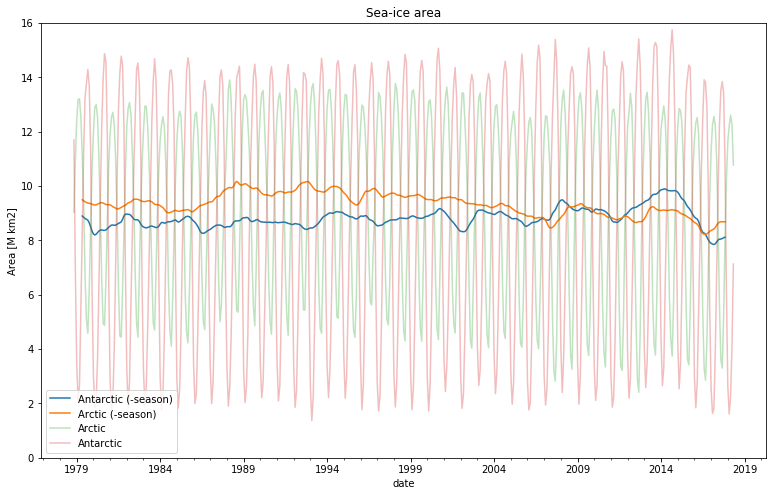

In [108]:
data_dir = pathlib.Path('/Users/baart_f/src/sealevel/data/sidads/')
data_paths = list(data_dir.glob('*extent_v3.0.csv'))
dfs = []
for path in data_paths:
    df = pd.read_csv(path, skipinitialspace=True, na_values=[-9999])
    dfs.append(df)
merged = pd.concat(dfs)
merged = merged.rename({'mo': 'month'}, axis='columns')
merged['day'] = 1
merged['date'] = pd.to_datetime(merged[['year', 'month', 'day']])



nh_df = merged[merged.region == 'N'].sort_values('date').set_index('date')
sh_df = merged[merged.region == 'S'].sort_values('date').set_index('date')


import statsmodels.tsa.seasonal

quantities = ['area', 'extent']
sh_df.loc[datetime.date(1987, 12, 1), quantities] = sh_df.loc[datetime.date(1986, 12, 1), quantities]
sh_df.loc[datetime.date(1988, 1, 1), quantities] = sh_df.loc[datetime.date(1987, 1, 1), quantities]
nh_df.loc[datetime.date(1987, 12, 1), quantities] = nh_df.loc[datetime.date(1986, 12, 1), quantities]
nh_df.loc[datetime.date(1987, 8, 1), 'area'] = nh_df.loc[datetime.date(1986, 8, 1), 'area']
nh_df.loc[datetime.date(1988, 1, 1), quantities] = nh_df.loc[datetime.date(1987, 1, 1), quantities]


fig, ax = plt.subplots(figsize=(13, 8))
sh_fit = statsmodels.tsa.seasonal.seasonal_decompose(sh_df['area'], freq=12)
sh_fit.trend.plot(label="Antarctic (-season)", ax=ax)
nh_fit = statsmodels.tsa.seasonal.seasonal_decompose(nh_df['area'], freq=12)
nh_fit.trend.plot(label="Arctic (-season)", ax=ax)
nh_df.area.plot(label='Arctic', alpha=0.3)
sh_df.area.plot(label='Antarctic', alpha=0.3)
ax.legend(loc='lower left')
ax.set_ylim(0, 16)
ax.set_ylabel('Area [M km2]')
ax.set_title('Sea-ice area')
fig.savefig('ice-trend.pdf')


In [78]:
nh_df[pd.isna(nh_df['area'])]

,year,month,data-type,region,extent,area,day
date,,,,,,,
1987-08-01,1987,8,Goddard,N,7.63,NaN,1


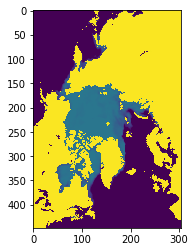

In [22]:
with rasterio.open('/Users/baart_f/Downloads/N_20160101_concentration_v3.0.tif') as ds:
    arr = ds.read(1)
    cmap = ds.colormap(1)
    rasterio.plot.show(ds)

In [122]:
# Classification Value Color (name/[RGB])
# sea ice concentration -> 0-1000 (divide by 10 to get percent)

# Shades of blue starting with dark blue [9, 60, 112], which is considered open ocean
# (0% ice), through light blue, which is considered varying concentrations of ice, to
# white [255, 255, 255] which is considered 100% ice. Note: Values from 1-150 (1%
# to 15% concentration) are statistically irrelevant because data values less than 15%
# from passive microwave instruments are too uncertain to use, so these should be
# ignored.

# ocean 0 dark blue [9, 60, 112]
# pole hole 2510 dark gray [79, 79, 79]
# coast line 2530 black [0, 0, 0]
# land 2540 gray [119, 119, 119]
# missing 2550 yellow [233, 203, 0]



In [136]:
sea_ice_concentration_promile = np.ma.masked_outside(arr, 1, 1000)
# compute concentration between 0 and 1
N = matplotlib.colors.Normalize(0, 1000)
sea_ice_concentration = N(sea_ice_concentration_promile)

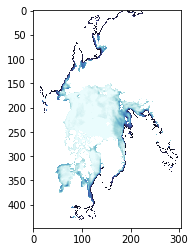

In [139]:
plt.imshow(sea_ice_concentration, cmap=cmocean.cm.ice)